# Deep VAE for captioning

This notebook was inspired from this github repository [here](https://github.com/shivakanthsujit/VAE-PyTorch/blob/master/VAE.ipynb). I tried to stay closer to the network described in [Variational Autoencoder for Deep Learning of Images, Labels and Captions](https://proceedings.neurips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Paper.pdf), however I didn't succeed in using stochastic pooling.

### Importing Dependencies

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.models as model
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import transforms
import os
import glob
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ConvLeak(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(),
        )
        
    def forward(self, x):
        return self.layer(x)
    
    
class ConvTransposeLeak(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(),
        )
        
    def forward(self, x):
        return self.layer(x)   

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, image_dim, latent_dim):
        
        super().__init__()
        
        # Some constants
        
        iW, iH = image_dim
        hW, hH = iW//4, iH//4
        vec_dim = out_channels * hW * hH
        
        self.layer1 = nn.Sequential(
            ConvLeak(in_channels=in_channels, out_channels=64),
            ConvLeak(in_channels=64, out_channels=64)
        )
        
        self.pooling = nn.MaxPool2d(2, return_indices=True)
        
        self.layer2 = nn.Sequential(
            ConvLeak(in_channels=64, out_channels=128),
            ConvLeak(in_channels=128, out_channels=128)
        )
        
        self.layer3 = nn.Sequential(
            ConvLeak(in_channels=128, out_channels=out_channels),
            nn.Flatten()
        )
        
        self.hidden = nn.Sequential(
            nn.Linear(in_features = vec_dim, out_features=latent_dim),
            nn.Tanh()
        )
            
        self.encoder_mean = nn.Linear(in_features = latent_dim, out_features = vec_dim)
        self.encoder_logstd = nn.Linear(in_features = latent_dim, out_features = vec_dim)
        
        
        
    def generate_code(self, mean, log_std):
        
        sigma = torch.exp(log_std)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean 
        
        
    def forward(self, x):
        
        x = self.layer1(x)
        x, indices_1 = self.pooling(x)
        x = self.layer2(x)
        x, indices_2 = self.pooling(x)
        x = self.layer3(x)
        hidden = self.hidden(x)
        mean, log_std = self.encoder_mean(hidden), self.encoder_logstd(hidden)
        c = self.generate_code(mean, log_std)
        
        return c, indices_1, indices_2, mean, log_std
        
        
        

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, image_dim):
        
        super().__init__()
        
        iW, iH = image_dim
        hW, hH = iW//4, iH//4
        
        self.layer3 = nn.Sequential(
            nn.Unflatten(1, unflattened_size=(in_channels, hW, hH)),
            ConvTransposeLeak(in_channels=in_channels, out_channels=128)
        )
        
        self.unpooling = nn.MaxUnpool2d(2)
        
        self.layer2 = nn.Sequential(
            ConvTransposeLeak(in_channels=128, out_channels=128),
            ConvTransposeLeak(in_channels=128, out_channels=64)
        )
        
        self.layer1 = nn.Sequential(
            ConvTransposeLeak(in_channels=64, out_channels=64),
            ConvTransposeLeak(in_channels=64, out_channels=out_channels)
        )
        
        self.precision = nn.Parameter(torch.rand(1))
        
        
    def generate_data(self, mean, precision):
        
        # Precision is 1/variance
        sigma = torch.exp(-precision)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean
        
    def forward(self, x, indices_1, indices_2):
        
        x = self.layer3(x)
        x = self.unpooling(x, indices_2)
        x = self.layer2(x)
        x = self.unpooling(x, indices_1)
        x = self.layer1(x)
        
        return x
#         return self.generate_data(x, self.precision)
        
        
        

In [5]:
class DVAE(nn.Module):
    
    def __init__(self, in_channels, image_dim, latent_dim):
        
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, out_channels=256, image_dim=image_dim, 
                               latent_dim=latent_dim)
        
        self.decoder = Decoder(in_channels=256, out_channels=in_channels, image_dim=image_dim)
        
    def forward(self, x):
        c, indices_1, indices_2, mean, log_std = self.encoder(x)
        x_new = self.decoder(c, indices_1, indices_2)
        
        return x_new, mean, log_std
        
        

# Dataset


Just using 8 images here as a proof of concept. 

In [18]:
class ImageDataset(Dataset):
    
    def __init__(self, transforms=None):
        
        self.images = glob.glob("../data/train/apple_*.jpg")
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx]).convert("RGB")
        
        if self.transforms:
            image = self.transforms(image)
        
        return image
    
    def __len__(self):
        return 8

In [19]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageDataset(transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training

In [20]:
model = DVAE(3, (32, 32), 100)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters())

In [21]:
losses = []
epochs = 100
for epoch in tqdm(range(epochs)):
    for image in dataloader:
        
        reconstructed, mean, log_std = model(image)
        reconstruction_error = criterion(reconstructed, image)
        KL_divergence = - (1 - mean.pow(2) - torch.exp(2 * log_std) + (2 *log_std)).sum()
        loss = reconstruction_error + KL_divergence
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()


        losses.append(loss.item())
        
        

In [22]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

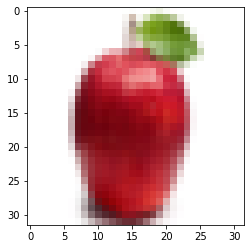

In [25]:
plt.imshow(invTrans(image[0]).permute(1, 2, 0))

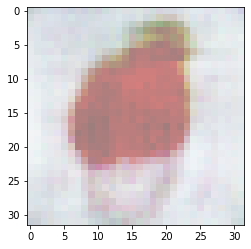

In [29]:
plt.imshow(torch.sigmoid(reconstructed[0].detach()).permute(1, 2, 0))

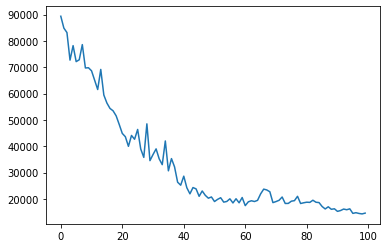

In [27]:
plt.plot(losses)